## Private Training

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
import pickle

import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from opacus import PrivacyEngine


In [2]:
def unpickle(file):
    """load the cifar-10 data"""

    with open(file, 'rb') as fo:
        data = pickle.load(fo, encoding='bytes')
    return data


def load_cifar_10_data(data_dir, negatives=False):
    """
    Return train_data, train_filenames, train_labels, test_data, test_filenames, test_labels
    """

    # get the meta_data_dict
    # num_cases_per_batch: 1000
    # label_names: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
    # num_vis: :3072

    meta_data_dict = unpickle(data_dir + "/batches.meta")
    cifar_label_names = meta_data_dict[b'label_names']
    cifar_label_names = np.array(cifar_label_names)

    # training data
    cifar_train_data = None
    cifar_train_filenames = []
    cifar_train_labels = []

    # cifar_train_data_dict
    # 'batch_label': 'training batch 5 of 5'
    # 'data': ndarray
    # 'filenames': list
    # 'labels': list

    for i in range(1, 6):
        cifar_train_data_dict = unpickle(data_dir + "/data_batch_{}".format(i))
        if i == 1:
            cifar_train_data = cifar_train_data_dict[b'data']
        else:
            cifar_train_data = np.vstack((cifar_train_data, cifar_train_data_dict[b'data']))
        cifar_train_filenames += cifar_train_data_dict[b'filenames']
        cifar_train_labels += cifar_train_data_dict[b'labels']

    cifar_train_data = cifar_train_data.reshape((len(cifar_train_data), 3, 32, 32))
    if negatives:
        cifar_train_data = cifar_train_data.transpose(0, 2, 3, 1).astype(np.float32)
    else:
        cifar_train_data = np.rollaxis(cifar_train_data, 1, 4)
    cifar_train_filenames = np.array(cifar_train_filenames)
    cifar_train_labels = np.array(cifar_train_labels)

    # test data
    # cifar_test_data_dict
    # 'batch_label': 'testing batch 1 of 1'
    # 'data': ndarray
    # 'filenames': list
    # 'labels': list

    cifar_test_data_dict = unpickle(data_dir + "/test_batch")
    cifar_test_data = cifar_test_data_dict[b'data']
    cifar_test_filenames = cifar_test_data_dict[b'filenames']
    cifar_test_labels = cifar_test_data_dict[b'labels']

    cifar_test_data = cifar_test_data.reshape((len(cifar_test_data), 3, 32, 32))
    if negatives:
        cifar_test_data = cifar_test_data.transpose(0, 2, 3, 1).astype(np.float32)
    else:
        cifar_test_data = np.rollaxis(cifar_test_data, 1, 4)
    cifar_test_filenames = np.array(cifar_test_filenames)
    cifar_test_labels = np.array(cifar_test_labels)

    return cifar_train_data, cifar_train_filenames, cifar_train_labels, \
        cifar_test_data, cifar_test_filenames, cifar_test_labels, cifar_label_names





Train data:  (50000, 32, 32, 3)
Train filenames:  (50000,)
Train labels:  (50000,)
Test data:  (10000, 32, 32, 3)
Test filenames:  (10000,)
Test labels:  (10000,)
Label names:  (10,)


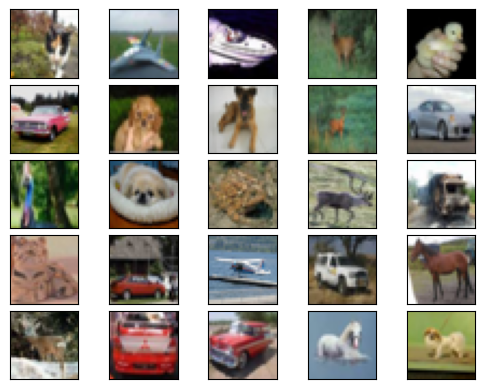

In [3]:

cifar_10_dir = 'cifar-10-batches-py'

train_data, train_filenames, train_labels, test_data, test_filenames, test_labels, label_names = \
    load_cifar_10_data(cifar_10_dir)

print("Train data: ", train_data.shape)
print("Train filenames: ", train_filenames.shape)
print("Train labels: ", train_labels.shape)
print("Test data: ", test_data.shape)
print("Test filenames: ", test_filenames.shape)
print("Test labels: ", test_labels.shape)
print("Label names: ", label_names.shape)

# Don't forget that the label_names and filesnames are in binary and need conversion if used.

num_plot = 5
f, ax = plt.subplots(num_plot, num_plot)
for m in range(num_plot):
    for n in range(num_plot):
        idx = np.random.randint(0, train_data.shape[0])
        ax[m, n].imshow(train_data[idx])
        ax[m, n].get_xaxis().set_visible(False)
        ax[m, n].get_yaxis().set_visible(False)
f.subplots_adjust(hspace=0.1)
f.subplots_adjust(wspace=0)
plt.show()

In [4]:
cifar_10_dir = 'cifar-10-batches-py'
train_data, train_filenames, train_labels, test_data, test_filenames, test_labels, label_names = load_cifar_10_data(cifar_10_dir)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(train_data, dtype=torch.float32)
y_train_tensor = torch.tensor(train_labels, dtype=torch.long)
X_test_tensor = torch.tensor(test_data, dtype=torch.float32)
y_test_tensor = torch.tensor(test_labels, dtype=torch.long)

# Normalizing
X_train_tensor = (X_train_tensor / 255.0)
X_test_tensor = (X_test_tensor / 255.0)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# training (80%) and validation (20%)
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

trainloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valloader = DataLoader(val_dataset, batch_size=64, shuffle=False)
testloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [5]:
X_train, X_val, y_train, y_val = train_test_split(train_data, train_labels, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).permute(0, 3, 1, 2)  # Change from NHWC to NCHW
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32).permute(0, 3, 1, 2)  # Change from NHWC to NCHW
y_val_tensor = torch.tensor(y_val, dtype=torch.long)
X_test_tensor = torch.tensor(test_data, dtype=torch.float32).permute(0, 3, 1, 2)  # Change from NHWC to NCHW
y_test_tensor = torch.tensor(test_labels, dtype=torch.long)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
trainloader = DataLoader(train_dataset, batch_size=64, shuffle=True)

val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
valloader = DataLoader(val_dataset, batch_size=64, shuffle=False)

test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
testloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

class CIFAR10Classifier(nn.Module):
    def __init__(self):
        super(CIFAR10Classifier, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, 1)
        self.conv2 = nn.Conv2d(16, 32, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(32 * 14 * 14, 64)  # Adjusted input size for the first fully connected layer
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        return x

# Training the baseline model
model_baseline = CIFAR10Classifier()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_baseline.parameters(), lr=0.001)

# Training function
def train_model(model, trainloader, criterion, optimizer, epochs):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, labels in trainloader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch {epoch + 1}, Loss: {running_loss / len(trainloader)}")



In [6]:
# epochs = 20
epochs = 15
train_model(model_baseline, trainloader, criterion, optimizer, epochs)

c:\Users\Matin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\functional.py:1374: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch 1, Loss: 2.3846886505126954
Epoch 2, Loss: 2.2290577058792116
Epoch 3, Loss: 1.9209580429077149
Epoch 4, Loss: 1.769277695274353
Epoch 5, Loss: 1.667229363822937
Epoch 6, Loss: 1.5696390687942505
Epoch 7, Loss: 1.515225009727478
Epoch 8, Loss: 1.4614006336212157
Epoch 9, Loss: 1.4037378560066223
Epoch 10, Loss: 1.363075604057312
Epoch 11, Loss: 1.3204232767105102
Epoch 12, Loss: 1.2927096757888794
Epoch 13, Loss: 1.2659076835632324
Epoch 14, Loss: 1.2401667384147643
Epoch 15, Loss: 1.2252686916351319


In [7]:
# # Save the baseline model
# torch.save(model_baseline.state_dict(), 'cifar10_model_baseline.pth')

In [8]:

def evaluate_model(model, testloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in testloader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    print(f'Accuracy: {accuracy}%')
    return accuracy

baseline_accuracy = evaluate_model(model_baseline, testloader)
print(f'Baseline Model Accuracy: {baseline_accuracy}%')

Accuracy: 59.33%
Baseline Model Accuracy: 59.33%


In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from opacus import PrivacyEngine


In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from sklearn.model_selection import train_test_split

# Function to clip gradients
def clip_gradients(model, max_grad_norm):
    total_norm = 0
    for p in model.parameters():
        if p.grad is not None:
            param_norm = p.grad.data.norm(2)
            total_norm += param_norm.item() ** 2
    total_norm = total_norm ** (1. / 2)
    clip_coef = max_grad_norm / (total_norm + 1e-6)
    if clip_coef < 1:
        for p in model.parameters():
            if p.grad is not None:
                p.grad.data.mul_(clip_coef)

# Function to add noise to gradients
def add_noise_to_gradients(model, noise_multiplier):
    for p in model.parameters():
        if p.grad is not None:
            noise = torch.normal(0, noise_multiplier, p.grad.data.size()).to(p.grad.device) / 4
            p.grad.data.add_(noise)

# Training function with dp
def train_model_with_privacy(model, trainloader, criterion, optimizer, max_grad_norm, noise_multiplier, epochs=10):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, labels in trainloader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            
            # # Clip gradients
            # clip_gradients(model, max_grad_norm)
            
            # Adding noise to gradients
            add_noise_to_gradients(model, noise_multiplier)
            
            optimizer.step()
            running_loss += loss.item()
        
        print(f"Epoch {epoch + 1}, Loss: {running_loss / len(trainloader)}")


In [11]:
def evaluate_model(model, dataloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

# Training parameters
# epochs = 25
epochs = 15
learning_rate = 0.001
max_grad_norm = 1.0
noise_multiplier = 1.0 / 4

model_privacy = CIFAR10Classifier()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_privacy.parameters(), lr=learning_rate)

train_model_with_privacy(model_privacy, trainloader, criterion, optimizer, max_grad_norm, noise_multiplier, epochs)




Epoch 1, Loss: 2.2247363580703734
Epoch 2, Loss: 1.988375869178772
Epoch 3, Loss: 1.90617583694458
Epoch 4, Loss: 1.8669472053527831
Epoch 5, Loss: 1.829821862411499
Epoch 6, Loss: 1.8130702587127685
Epoch 7, Loss: 1.7923489822387695
Epoch 8, Loss: 1.7816669813156127
Epoch 9, Loss: 1.768803722190857
Epoch 10, Loss: 1.751658708000183
Epoch 11, Loss: 1.7486208757400512
Epoch 12, Loss: 1.7387656843185424
Epoch 13, Loss: 1.7355189470291137
Epoch 14, Loss: 1.7315501401901245
Epoch 15, Loss: 1.7286174522399902


In [12]:
privacy_accuracy = evaluate_model(model_privacy, testloader)
print(f'Privacy-enhanced Model Accuracy: {privacy_accuracy:.2f}%')

Privacy-enhanced Model Accuracy: 45.94%


In [13]:
# # Save the privacy-enhanced model
# torch.save(model_privacy.state_dict(), 'cifar10_model_privacy.pth')

In [14]:
# Splitting training data into seen and unseen sets
seen_data, unseen_data, seen_labels, unseen_labels = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

# Combining unseen data with test data
unseen_data = np.concatenate((unseen_data, test_data), axis=0)
unseen_labels = np.concatenate((unseen_labels, test_labels), axis=0)

# Converting to PyTorch tensors
seen_data_tensor = torch.tensor(seen_data, dtype=torch.float32).permute(0, 3, 1, 2)
seen_labels_tensor = torch.tensor(seen_labels, dtype=torch.long)
unseen_data_tensor = torch.tensor(unseen_data, dtype=torch.float32).permute(0, 3, 1, 2)
unseen_labels_tensor = torch.tensor(unseen_labels, dtype=torch.long)

seen_dataset = TensorDataset(seen_data_tensor, seen_labels_tensor)
seen_loader = DataLoader(seen_dataset, batch_size=64, shuffle=True)

unseen_dataset = TensorDataset(unseen_data_tensor, unseen_labels_tensor)
unseen_loader = DataLoader(unseen_dataset, batch_size=64, shuffle=False)


In [15]:
def train_shadow_model(data_loader):
    model = CIFAR10Classifier()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    model.train()
    for epoch in range(5):  # Train for fewer epochs for shadow models
        running_loss = 0.0
        for inputs, labels in data_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
    
    return model

# Training multiple shadow models
num_shadow_models = 5
shadow_models = []
for _ in range(num_shadow_models):
    shadow_model = train_shadow_model(seen_loader)
    shadow_models.append(shadow_model)


In [16]:
def get_attack_data(shadow_models, data_loader):
    member_probs = []
    non_member_probs = []
    
    for model in shadow_models:
        model.eval()
        with torch.no_grad():
            for inputs, labels in data_loader:
                outputs = model(inputs)
                probs = torch.softmax(outputs, dim=1)
                
                for i in range(len(inputs)):
                    if labels[i] == torch.argmax(probs[i]):
                        member_probs.append(probs[i].cpu().numpy())
                    else:
                        non_member_probs.append(probs[i].cpu().numpy())
    
    return np.array(member_probs), np.array(non_member_probs)

member_probs, non_member_probs = get_attack_data(shadow_models, seen_loader)
non_member_probs_test, _ = get_attack_data(shadow_models, unseen_loader)


In [17]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Preparing attack model data
X_attack = np.vstack((member_probs, non_member_probs))
y_attack = np.hstack((np.ones(len(member_probs)), np.zeros(len(non_member_probs))))

# Spliting the attack data into training and validation sets
X_attack_train, X_attack_val, y_attack_train, y_attack_val = train_test_split(
    X_attack, y_attack, test_size=0.2, random_state=42
)

# Training an attack model (e.g., a RandomForest)
attack_model = RandomForestClassifier(n_estimators=100)
attack_model.fit(X_attack_train, y_attack_train)


y_attack_pred = attack_model.predict(X_attack_val)
attack_accuracy = accuracy_score(y_attack_val, y_attack_pred)
print(f"Attack Model Accuracy: {attack_accuracy:.2f}")


Attack Model Accuracy: 0.69


In [18]:
def evaluate_attack_model(attack_model, target_model, data_loader):
    target_model.eval()
    attack_data = []

    with torch.no_grad():
        for inputs, labels in data_loader:
            outputs = target_model(inputs)
            probs = torch.softmax(outputs, dim=1)
            attack_data.append(probs.cpu().numpy())

    attack_data = np.vstack(attack_data)
    attack_preds = attack_model.predict(attack_data)
    return attack_preds

model_baseline.eval()
baseline_member_probs, baseline_non_member_probs = get_attack_data([model_baseline], seen_loader)
baseline_attack_preds = evaluate_attack_model(attack_model, model_baseline, unseen_loader)

model_privacy.eval()
privacy_member_probs, privacy_non_member_probs = get_attack_data([model_privacy], seen_loader)
privacy_attack_preds = evaluate_attack_model(attack_model, model_privacy, unseen_loader)

baseline_attack_accuracy = accuracy_score(np.ones(len(baseline_attack_preds)), baseline_attack_preds) * 100
privacy_attack_accuracy = accuracy_score(np.zeros(len(privacy_attack_preds)), privacy_attack_preds) * 100

print(f"Baseline Model Attack Accuracy: {baseline_attack_accuracy:.2f}")
print(f"Privacy-Enhanced Model Attack Accuracy: {privacy_attack_accuracy:.2f}")


c:\Users\Matin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\functional.py:1374: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)
c:\Users\Matin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\functional.py:1374: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.war

Baseline Model Attack Accuracy: 74.36
Privacy-Enhanced Model Attack Accuracy: 54.63


In [19]:
# more shadow models to improve the attack model
num_shadow_models = 10  # Increased number of shadow models
shadow_models = []
for _ in range(num_shadow_models):
    shadow_model = train_shadow_model(seen_loader)
    shadow_models.append(shadow_model)


member_probs, non_member_probs = get_attack_data(shadow_models, seen_loader)
non_member_probs_test, _ = get_attack_data(shadow_models, unseen_loader)


X_attack = np.vstack((member_probs, non_member_probs))
y_attack = np.hstack((np.ones(len(member_probs)), np.zeros(len(non_member_probs))))
X_attack_train, X_attack_val, y_attack_train, y_attack_val = train_test_split(
    X_attack, y_attack, test_size=0.2, random_state=42
)
attack_model.fit(X_attack_train, y_attack_train)
y_attack_pred = attack_model.predict(X_attack_val)
improved_attack_accuracy = accuracy_score(y_attack_val, y_attack_pred)
print(f"Improved Attack Model Accuracy: {improved_attack_accuracy:.2f}")


baseline_attack_preds = evaluate_attack_model(attack_model, model_baseline, unseen_loader)
privacy_attack_preds = evaluate_attack_model(attack_model, model_privacy, unseen_loader)

baseline_attack_accuracy = accuracy_score(np.ones(len(baseline_attack_preds)), baseline_attack_preds)
privacy_attack_accuracy = accuracy_score(np.zeros(len(privacy_attack_preds)), privacy_attack_preds)

print(f"Baseline Model Improved Attack Accuracy: {baseline_attack_accuracy:.2f}")
print(f"Privacy-Enhanced Model Improved Attack Accuracy: {privacy_attack_accuracy:.2f}")


c:\Users\Matin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\functional.py:1374: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


KeyboardInterrupt: 

In [ ]:
print(f"Baseline Model Improved Attack Accuracy: {baseline_attack_accuracy*100:.2f}")
print(f"Privacy-Enhanced Model Improved Attack Accuracy: {privacy_attack_accuracy*100:.2f}")

Baseline Model Improved Attack Accuracy: 78.53
Privacy-Enhanced Model Improved Attack Accuracy: 84.98


In [ ]:
model = CIFAR10Classifier()
state_dict = torch.load("model_state_dict.pth", map_location=torch.device('cpu'))
from collections import OrderedDict
new_state_dict = OrderedDict()

for k, v in state_dict.items():
       new_key=k.replace('_module.','')
       new_state_dict[new_key]=v

model.load_state_dict(new_state_dict)


model.eval()
privacy_member_probs, privacy_non_member_probs = get_attack_data([model], seen_loader)
privacy_attack_preds = evaluate_attack_model(attack_model, model , unseen_loader)
privacy_attack_accuracy=accuracy_score(np.ones(len(privacy_attack_preds)), privacy_attack_preds) * 100
print(f"Privacy-Enhanced Model Attack Accuracy: {privacy_attack_accuracy:.2f}")

c:\Users\Matin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\functional.py:1374: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Privacy-Enhanced Model Attack Accuracy: 99.33


In [ ]:
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from torchvision.datasets import CIFAR10
# from torchvision import transforms
# from torch.utils.data import Subset, DataLoader, TensorDataset
# from sklearn.metrics import confusion_matrix, precision_score, recall_score ,f1_score
# from sklearn.linear_model import LogisticRegression
# import random

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# model = CIFAR10Classifier()
# state_dict = torch.load("model_state_dict.pth", map_location=device)
# new_state_dict = {key.replace('_module.', ''): value for key, value in state_dict.items()}
# model.load_state_dict(new_state_dict)
# model.to(device)
# model.eval()

# transform = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
# ])

# DATA_ROOT = '../cifar10'
# BATCH_SIZE = 64

# #Load the indices from list.txt
# indices_file = 'list.txt' ############
# with open(indices_file, 'r') as f:
#     indices = [int(line.strip()) for line in f]

# #num_indices = 10
# #indices_file = random.sample(range(100), num_indices)


# full_train_dataset = CIFAR10(root=DATA_ROOT, train=True, download=True, transform=transform)
# test_dataset = CIFAR10(root=DATA_ROOT, train=False, download=True, transform=transform)

# train_indices_set = set(indices)
# all_indices = set(range(len(full_train_dataset)))
# other_indices = list(all_indices - train_indices_set)

# train_dataset = Subset(full_train_dataset, indices[:len(indices)//2])  ###########
# other_dataset = Subset(full_train_dataset, other_indices)

# # Create data loaders
# train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)
# other_loader = DataLoader(other_dataset, batch_size=BATCH_SIZE, shuffle=False)
# test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# # Create labels
# train_labels = torch.ones(len(train_dataset)).to(device)
# other_labels = torch.zeros(len(other_dataset)).to(device)
# test_labels = torch.zeros(len(test_dataset)).to(device)
# ####################################
# #if you have an attacker model for each class, modify the above code.
# ####################################

# def extract_features(model, dataloader):
#     model.eval()
#     features = []
#     with torch.no_grad():
#         for data in dataloader:
#             inputs, _ = data
#             inputs = inputs.to(device)
#             outputs = model(inputs)
#             features.append(outputs)
#     return torch.cat(features).to(device)

# train_features = extract_features(model, train_loader)
# other_features = extract_features(model, other_loader)
# test_features = extract_features(model, test_loader)


# combined_features = torch.cat((train_features, other_features, test_features))
# combined_labels = torch.cat((train_labels, other_labels, test_labels))


# new_dataset = TensorDataset(combined_features, combined_labels)
# new_loader = DataLoader(new_dataset, batch_size=BATCH_SIZE, shuffle=True)

# #load your attacker model

# #############################################

# # Calculate training accuracy, confusion matrix, precision, and recall
# #binary_classifier.eval()
# all_labels = []
# all_predicted = []
# correct = 0
# total = 0

# with torch.no_grad():
#     for features, labels in new_loader:
#         features, labels = features.to(device), labels.to(device)
#         attack_preds=attack_model.predict(features)
#         outputs = attack_preds.squeeze()
#         predicted = (outputs > 0.5)
#         total += labels.size(0)
#         correct += torch.sum(predicted == torch.from_numpy(labels).float()).item()
#         all_labels.extend(labels.cpu().numpy())
#         all_predicted.extend(predicted.cpu().numpy())

# accuracy = correct / total
# print(f'Training Accuracy: {accuracy:.4f}')

# cm = confusion_matrix(all_labels, all_predicted)
# precision = precision_score(all_labels, all_predicted)
# recall = recall_score(all_labels, all_predicted)
# f1 = f1_score(all_labels, all_predicted)

# print(f'Confusion Matrix:\n{cm}')
# print(f"Precision: {precision:.4f}")
# print(f"Recall: {recall:.4f}")
# print(f"F1 Score: {f1:.4f}")

  1%|▏         | 2359296/170498071 [01:27<1:43:41, 27024.25it/s]


KeyboardInterrupt: 

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.datasets import CIFAR10
from torchvision import transforms
from torch.utils.data import Subset, DataLoader, TensorDataset
from sklearn.metrics import confusion_matrix, precision_score, recall_score ,f1_score
from sklearn.linear_model import LogisticRegression
import random

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = CIFAR10Classifier()
state_dict = torch.load("model_state_dict.pth", map_location=device)
new_state_dict = {key.replace('_module.', ''): value for key, value in state_dict.items()}
model.load_state_dict(new_state_dict)
model.to(device)
model.eval()

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

DATA_ROOT = '../cifar10'
BATCH_SIZE = 64

#Load the indices from list.txt
indices_file = 'list.txt' ############
with open(indices_file, 'r') as f:
    indices = [int(line.strip()) for line in f]

#num_indices = 10
#indices_file = random.sample(range(100), num_indices)


full_train_dataset = CIFAR10(root=DATA_ROOT, train=True, download=True, transform=transform)
test_dataset = CIFAR10(root=DATA_ROOT, train=False, download=True, transform=transform)
    

train_indices_set = set(indices)
all_indices = set(range(len(full_train_dataset)))
other_indices = list(all_indices - train_indices_set)

train_dataset = Subset(full_train_dataset, indices[:len(indices)//2])  ###########
other_dataset = Subset(full_train_dataset, other_indices)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)
other_loader = DataLoader(other_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Create labels
train_labels = torch.ones(len(train_dataset)).to(device)
other_labels = torch.zeros(len(other_dataset)).to(device)
test_labels = torch.zeros(len(test_dataset)).to(device)
####################################
#if you have an attacker model for each class, modify the above code.
####################################

def extract_features(model, dataloader):
    model.eval()
    features = []
    with torch.no_grad():
        for data in dataloader:
            inputs, _ = data
            inputs = inputs.to(device)
            outputs = model(inputs)
            features.append(outputs)
    return torch.cat(features).to(device)

train_features = extract_features(model, train_loader)
other_features = extract_features(model, other_loader)
test_features = extract_features(model, test_loader)


combined_features = torch.cat((train_features, other_features, test_features))
combined_labels = torch.cat((train_labels, other_labels, test_labels))


new_dataset = TensorDataset(combined_features, combined_labels)
new_loader = DataLoader(new_dataset, batch_size=BATCH_SIZE, shuffle=True)

#load your attacker model

#############################################

# Calculate training accuracy, confusion matrix, precision, and recall
#binary_classifier.eval()
all_labels = []
all_predicted = []
correct = 0
total = 0

# with torch.no_grad():
#     for features, labels in new_loader:
#         features, labels = features.to(device), labels.to(device)
#         attack_preds=attack_model.predict(features)
#         outputs = attack_preds.squeeze()
#         predicted = (outputs > 0.5)
#         total += labels.size(0)
#         correct += torch.sum(predicted == torch.from_numpy(labels).float()).item()
#         all_labels.extend(labels.cpu().numpy())
#         all_predicted.extend(predicted.cpu().numpy())

with torch.no_grad():
    for features, labels in new_loader:
        features, labels = features.to(device), labels.to(device)
        attack_preds=attack_model.predict(features)
        outputs = attack_preds.squeeze()
        predicted = np.float64((outputs <= 0.5))
        print(predicted)
        print(labels)
        total += labels.size(0)
        correct += np.float64((predicted== labels.numpy())).sum().item()
        print(correct)
        all_labels.extend(labels.cpu().numpy())
        all_predicted.extend(predicted)

accuracy = correct / total
print(f'Training Accuracy: {accuracy:.4f}')

cm = confusion_matrix(all_labels, all_predicted)
precision = precision_score(all_labels, all_predicted)
recall = recall_score(all_labels, all_predicted)
f1 = f1_score(all_labels, all_predicted)

print(f'Confusion Matrix:\n{cm}')
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")